In [1]:
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from scipy import sparse
from sklearn.decomposition import PCA, TruncatedSVD

# Load and Preprocess Data
Filter our users based on total play count and drop unnecessary columns.


In [2]:
user_df = pd.read_csv("../data/filtered_user_df.csv")
user_df.drop(columns=["Unnamed: 0", "Unnamed: 0.1"], inplace=True)


In [3]:
user_df.head()

,user,artist_name,play_count,artist_url
0,nyancrimew,Jasmine Thompson,7559.0,https://www.last.fm/music/Jasmine+Thompson
1,nyancrimew,Eminem,5851.0,https://www.last.fm/music/Eminem
2,nyancrimew,Watsky,3044.0,https://www.last.fm/music/Watsky
3,nyancrimew,Linkin Park,2938.0,https://www.last.fm/music/Linkin+Park
4,nyancrimew,twenty one pilots,1849.0,https://www.last.fm/music/twenty+one+pilots


In [4]:
# Getting total play counts for users and filtered some out 

user_total_play = (
    user_df.groupby("user")["play_count"]
    .sum()
    .reset_index(name="total_play_count")
)
filtered_users = user_total_play[
    user_total_play["total_play_count"] >= 50000
]["user"]
filtered_df = user_df[user_df["user"].isin(filtered_users)]
filtered_df['play_count'] = filtered_df['play_count'].map(lambda x: 1)

C:\Users\joshu\AppData\Local\Temp\ipykernel_16724\3519592273.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['play_count'] = filtered_df['play_count'].map(lambda x: 1)


In [5]:
filtered_df.head()

,user,artist_name,play_count,artist_url
138,angilbertomnz,Lady Gaga,1,https://www.last.fm/music/Lady+Gaga
139,angilbertomnz,Beyoncé,1,https://www.last.fm/music/Beyonc%C3%A9
140,angilbertomnz,Natasha Bedingfield,1,https://www.last.fm/music/Natasha+Bedingfield
141,angilbertomnz,Madonna,1,https://www.last.fm/music/Madonna
142,angilbertomnz,Christina Aguilera,1,https://www.last.fm/music/Christina+Aguilera


Convert this to a sparse matrix. Start by mapping users and artists to a unique numeric value.

In [6]:
user_ids = filtered_df["user"].unique()
artist_names = filtered_df["artist_name"].unique()

user_to_idx = {user: i for i, user in enumerate(user_ids)}
artist_to_idx = {artist: j for j, artist in enumerate(artist_names)}

# Convert rows to (row index, column index, value) tuples
rows = filtered_df["user"].map(user_to_idx)
cols = filtered_df["artist_name"].map(artist_to_idx)
values = filtered_df["play_count"]
sparse_matrix = sparse.coo_matrix(
    (values, (rows, cols)), shape=(len(user_ids), len(artist_names))
)


In [7]:
# View sparse matrix
dense_matrix = sparse_matrix.todense()

row, col, data = sparse.find(sparse_matrix)

for r, c, d in zip(row[:10], col[:10], data[:10]):
    print(f"User index: {r}, Artist index: {c}, Play count: {d}")


User index: 0, Artist index: 0, Play count: 1
User index: 2, Artist index: 0, Play count: 1
User index: 12, Artist index: 0, Play count: 1
User index: 16, Artist index: 0, Play count: 1
User index: 17, Artist index: 0, Play count: 1
User index: 20, Artist index: 0, Play count: 1
User index: 25, Artist index: 0, Play count: 1
User index: 33, Artist index: 0, Play count: 1
User index: 35, Artist index: 0, Play count: 1
User index: 42, Artist index: 0, Play count: 1


Load in the artist location data.

In [8]:
with open('../data/artist_location_codes.json', 'r') as file:
    artist_locations = json.load(file)
priveleged_locations = ['US', 'CA', 'GB']

# Collabroative Filtering
Use `TruncatedSVD`.

**Collaborative Filtering**: Assumption is that if users $A$ and $B$ rate items similarly, $A$ is more likely to have $B$'s opinion on an item (artist) than that of another randomly chosen user.

Use **SVD** to decompose the original sparse matrix (users' interactions with items, i.e., play counts) into lower-dimensional matrices, capturing latent factors with users and items.

In [9]:
num_components = 50  # Number of latent factors to represent users and items

# Matrix factorization with TruncatedSVD
svd = TruncatedSVD(n_components=num_components, random_state=42)

user_features = svd.fit_transform(
    sparse_matrix
)  # Represent the users in the reduced latent factor space.
item_features = svd.components_
user_ratings = np.dot(user_features, item_features)

## Visualize Artist Latent Features with PCA

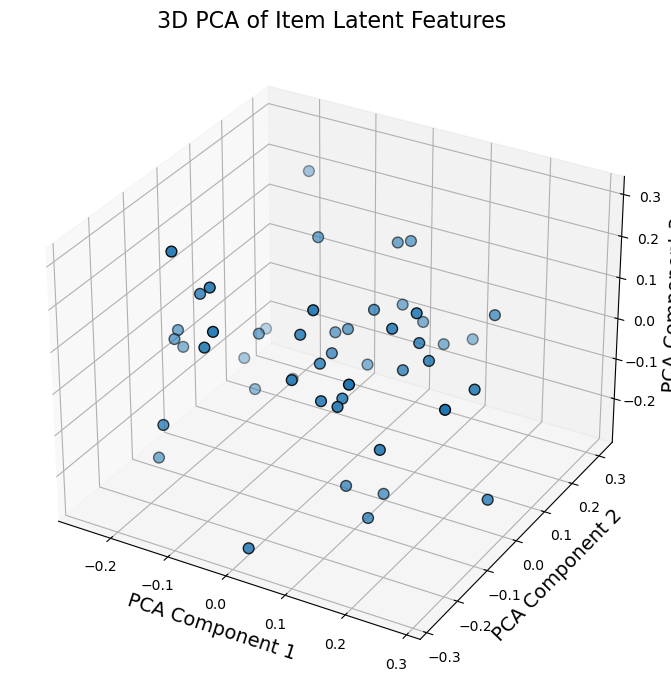

In [10]:
def visualize_latent_features(
    _item_features: np.ndarray, item_labels: list[int] = None
) -> None:
    pca = PCA(n_components=3)
    reduced_features = pca.fit_transform(_item_features)

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection="3d")

    if item_labels is not None:
        for i, label in enumerate(item_labels):
            ax.scatter(
                reduced_features[i, 0],
                reduced_features[i, 1],
                reduced_features[i, 2],
                label=label,
                edgecolor="k",
                s=60,
            )
        ax.legend(fontsize="small", loc="best")
    else:
        ax.scatter(
            reduced_features[:, 0],
            reduced_features[:, 1],
            reduced_features[:, 2],
            edgecolor="k",
            s=60,
        )

    ax.set_xlabel("PCA Component 1", fontsize=14)
    ax.set_ylabel("PCA Component 2", fontsize=14)
    ax.set_zlabel("PCA Component 3", fontsize=14)
    ax.set_title("3D PCA of Item Latent Features", fontsize=16)
    plt.tight_layout()
    plt.show()


visualize_latent_features(item_features)


In [11]:
# idx_to_artist = {idx: artist for artist, idx in artist_to_idx.items()}


# def recommend_artists(
#     _user_id: int,
#     _user_features: np.ndarray,
#     _item_features: np.ndarray,
#     top_n: int = 5,
#     underrepresented_weight = 1
# ) -> list[str]:
#     # Convert 
#     # Predicted rating is the dot product of `user_factors` and `item_factors`. Will be the same shape as the original matrix, and the element will represent the predicted interaction (play count) with an artist.
#     predicted_ratings = np.dot(_user_features, _item_features)
#     user_ratings = predicted_ratings[_user_id, :]
#     print(_item_features.shape)
#     # Calculate reweighting vector TODO: There has to be a less computationally intense way of calculating this
#     reweighting_vec = np.array([(1 if artist_locations[artist] in priveleged_locations else underrepresented_weight) for artist in artist_names])
#     reweighted_ratings = user_ratings * reweighting_vec
#     recommended_item_idx = np.argsort(reweighted_ratings)[::-1]
#     # This is horribly inefficient, optimize
#     recommended_artist_names = [
#         idx_to_artist[idx] for idx in recommended_item_idx
#     ]
#     username = idx_to_user[_user_id]
#     user_listened_artists = filtered_df[filtered_df['user'] == username]['artist_name']
#     for artist in user_listened_artists:
#         recommended_artist_names.remove(artist)
#     return recommended_artist_names[:top_n]


In [12]:
popularity_df = filtered_df.applymap(lambda x: artist_to_idx[x] if x in artist_to_idx else 0, na_action='ignore')
popularity_rank = popularity_df.groupby('artist_name')['user'].count()

In [13]:
idx_to_artist = {idx: artist for artist, idx in artist_to_idx.items()}


def recommend_artists(
    _user_liked_artists: list,
    _item_features: np.ndarray,
    top_n: int = 5,
    underrepresented_weight = 1,
    popularity_weight = 0
) -> list[str]:
    # Convert liked artists to user features
    user_info_array = np.array([[int(artist in _user_liked_artists) for artist in artist_names]])
    user_features = svd.transform(user_info_array)
    # Predicted rating is the dot product of `user_factors` and `item_factors`. Will be the same shape as the original matrix, and the element will represent the predicted interaction (play count) with an artist.
    user_ratings = np.dot(user_features, _item_features)
    # Calculate reweighting vector TODO: There has to be a less computationally intense way of calculating this
    reweighting_vec = np.array([(1 if artist_locations[artist] in priveleged_locations else underrepresented_weight) for artist in artist_names])
    popularity_weighting_vec = ((1 - (popularity_rank / max(popularity_rank))) ** popularity_weight).array
    print(user_ratings.shape, reweighting_vec.shape, popularity_weighting_vec.shape)
    reweighted_ratings = user_ratings * reweighting_vec * popularity_weighting_vec
    user_artist_idxs = [artist_to_idx[artist] for artist in get_user_liked_artists(0)]
    for idx in user_artist_idxs:
        reweighted_ratings[0][idx] = 0
    recommended_item_idx = np.argsort(reweighted_ratings[0])[::-1]
    # match = user_ratings[0][recommended_item_idx[:top_n]].sum() / len(_user_liked_artists) # THIS IS NOT CORRECT
    # This is horribly inefficient, optimize
    recommended_artist_names = [
        idx_to_artist[idx] for idx in recommended_item_idx
    ]
    return recommended_artist_names[:top_n]


In [14]:
# Example
idx_to_user = {idx: user for user, idx in user_to_idx.items()}

def get_user_liked_artists(user_id):
    # Returns a list of names of artists the user likes
    liked_artists = filtered_df[filtered_df['user'] == filtered_df['user'].iloc[user_id]]['artist_name'].array
    return liked_artists

def recommend_for_user(user_id: int, top_n: int, underrepresented_weight = 1, popularity_weight = float('inf')) -> None:
    recommended_artists = recommend_artists(
        get_user_liked_artists(user_id), item_features, top_n, underrepresented_weight, popularity_weight
    )
    username = idx_to_user[user_id]
    print(f"Recommended artists for user {username}: {recommended_artists}")


recommend_for_user(0, 10, 3, 100)

# TODO: Solve the David Guetta Problem

(1, 23925) (23925,) (23925,)
Recommended artists for user angilbertomnz: ['Shontelle', 'Yuridia', 'Havana Brown', 'Paulina Rubio', 'Ximena Sariñana', 'Esmée Denters', 'Gaby Amarantos', 'Alexandra Stan', 'Agridoce', 'Gloria Trevi']


In [15]:
# avg_match is the average of the match scores given by the model to the artists it recommends. We want to maximize this
# underrepresented_proportion is the percentage of recommended artists that are from underrepresented countries. We want to maximize this
def calc_metrics(top_n = 10, underrepresented_weight = 1, popularity_weight = 0):
    num_users = user_features.shape[0]
    underrepresented_count = 0
    total_artist_count = 0
    total_match = 0
    mean_popularity_rank = 0
    popularity_weighting_vec = ((1 - (popularity_rank / max(popularity_rank))) ** popularity_weight).array
    for i in range(num_users):
        # if i % 100 == 0:
        #     print(i)

        user_liked_artists = get_user_liked_artists(i)
        rating_row = user_ratings[i]
        user_artist_idxs = [artist_to_idx[artist] for artist in user_liked_artists]
        reweighting_vec = np.array([(1 if artist_locations[artist] in priveleged_locations else underrepresented_weight) for artist in artist_names])
        reweighted_ratings = rating_row * reweighting_vec * popularity_weighting_vec
        for idx in user_artist_idxs:
            reweighted_ratings[idx] = 0
        
        recommended_item_idx = np.argsort(reweighted_ratings)[::-1]
        match = user_ratings[i][recommended_item_idx[:top_n]].sum() / len(user_liked_artists)
        total_match += match
        
        underrepresented_artists = [artist_locations[idx_to_artist[idx]] not in priveleged_locations for idx in recommended_item_idx[:top_n]]
        underrepresented_count += sum(underrepresented_artists)
        # Artist Popularity Bias (APB)
        mean_popularity_rank += popularity_rank[recommended_item_idx[:top_n]].sum()
        total_artist_count += len(underrepresented_artists)
        

    avg_match = total_match / num_users
    underrepresented_proportion = underrepresented_count / total_artist_count
    mean_popularity_rank /= total_artist_count
    return avg_match, underrepresented_proportion, mean_popularity_rank

In [ ]:
# Grid search over the metrics
search_results = {}
for underrepresented_weight in [1, 2, 3, 5, 7]:
    for popularity_weight in [0, 1, 2, 3, 5, 7]:
        search_results[(underrepresented_weight, popularity_weight)] = calc_metrics(10, underrepresented_weight, popularity_weight)
        print(f'Logged {underrepresented_weight, popularity_weight}')

Logged (1, 0)
Logged (1, 1)


# Metrics

In [ ]:
def simulate_user_satisfaction(
    user_indices: list[int],
    _item_features: np.ndarray,
    _sparse_matrix: sparse.coo_matrix,
    top_n: int = 5,
) -> None:
    satisfaction_scores = []

    for user_id in user_indices:
        recommended_artists = recommend_artists(
            get_user_liked_artists(user_id), _item_features, top_n
        )

        # Identify user interactions.
        user_interactions = _sparse_matrix.getrow(user_id).nonzero()[1]
        interacted_artists = [idx_to_artist[idx] for idx in user_interactions]
        satisfaction = set(recommended_artists).intersection(
            set(interacted_artists)
        )
        satisfaction_scores.append(len(satisfaction) / top_n)

    plt.figure(figsize=(10, 6))
    plt.plot(
        user_indices,
        satisfaction_scores,
        marker="o",
        linestyle="--",
        color="darkorange",
        markersize=8,
    )
    plt.xlabel("User Index", fontsize=14)
    plt.ylabel("Satisfaction Score", fontsize=14)
    plt.title("User Satisfaction Across Sample Users", fontsize=16)
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()


simulate_user_satisfaction(
    sample_user_indices, item_features, sparse_matrix
)
